# 0. Business Goal

The objective is to analyze customer behavior and needs through customer segmentation and cluster similar customers based on their purchasing patterns. Using these insights, I aim to build a recommendation system - item based collaborative filtering to enhance user engagement and identify potential purchases.

I especially built a item-based collaborative filtering with these reasons. First of all, the dataset has a large number of transactional records with CustomerID - Item - Timestamp structure, while doesn't have much user profile info. However, it has enough data on what users purchased, enabling to interpret, "Customers who bought X also bought Y."


\\
Algorithm

#1. Data Load

In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# data analytics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1-1. Kaggle Load

In [3]:
# import data from kaggle
from google.colab import userdata
from os import listdir

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d carrie1/ecommerce-data

! unzip "ecommerce-data.zip"

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 253MB/s]
Archive:  ecommerce-data.zip
  inflating: data.csv                


In [5]:
os.listdir()

['.config', 'drive', 'data.csv', 'ecommerce-data.zip', 'sample_data']

In [6]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

#2. Data Exploring - Overview

Let's see how data looks like.

Here we have a single transaction of each customerID with different descriptions(items), different stock codes, and different countries.

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# statistical info for numerical values

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Inference for Numerical Values

## 2-1. Quantity

- The average value for quantity is 9.55, which seems reasonable.
- However, this feature has a wide range, with a maximum value of 80,995 and a minimum of -80,995. Ordering 80,995 items doesnt seem plausible, and a negative quantity is also questionable. I'll first check the boxplot to determine whether these values are part of a regular pattern or outliers, and decide accordingly.
- Referring to the plot below, these values cleary appear to be outliers and should be handled appropriately.

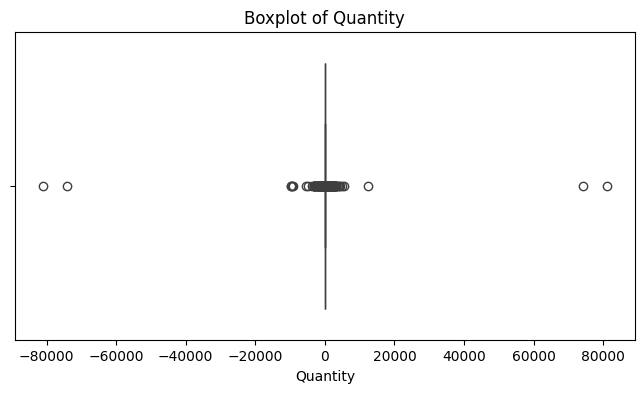

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')
plt.show()

## 2-2. Unit Price

- First of all, we can create a new feature - TotalPrice by multiplying quantity and unit price.
- While the UnitPrice values between the 25th and 75th percentiles appear reasonable, the maximum value of 38,987 seems questionable. Referring to the boxplot, this value clearly stands out as an outlier.

In [ ]:
df["UnitPrice"].quantile([0.25, 0.5, 0.75, 1])

,UnitPrice
0.25,1.25
0.50,2.08
0.75,4.13
1.00,38970.00


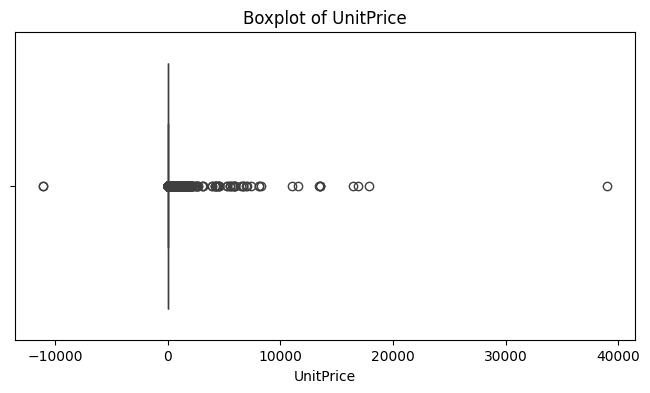

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

- Let's take a closer look at these values. Referring to the table below, the rows with unusually high UnitPrice values tend to have irregular StockCode, negative Quantity, InvoiceNo starting with characters like 'C' or 'B', and some null values in CustomerID.
- Based on this observation, it appears that InvoiceNo Starting with 'C' and negative Quantity may indicate canceled transactions. These should be considered important features during data preprocessing.
- Such anomalies - like negative quantities and canceled invoices - may contribute to abnormal UnitPrice values. Therefore, we will re-evaluate the UnitPrice statistics after appropriate data cleaning and preprocessing.

In [ ]:
df.sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,6/10/2011 15:31,38970.00,15098.0,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:36,17836.46,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:55,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:57,16453.71,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:49,13541.33,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:34,13474.79,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:35,11586.50,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom


In [ ]:
df[df['Quantity'] > 0]['UnitPrice'].quantile([0.25, 0.5, 0.75, 1])

,UnitPrice
0.25,1.25
0.50,2.08
0.75,4.13
1.00,13541.33


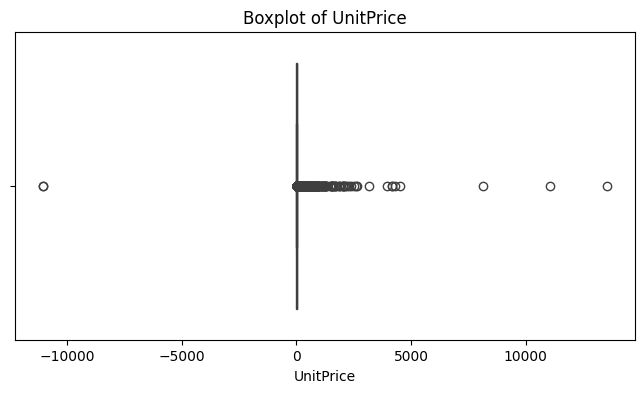

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df[df['Quantity'] > 0]['UnitPrice'])
plt.title('Boxplot of UnitPrice')
plt.xlabel('UnitPrice')
plt.show()

In [ ]:
df[df['Quantity']>0].sort_values(by='UnitPrice', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15017,537632,AMAZONFEE,AMAZON FEE,1,12/7/2010 15:08,13541.33,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom
297723,562955,DOT,DOTCOM POSTAGE,1,8/11/2011 10:14,4505.17,NaN,United Kingdom
268028,560373,M,Manual,1,7/18/2011 12:30,4287.63,NaN,United Kingdom
422376,573080,M,Manual,1,10/27/2011 14:20,4161.06,12536.0,France
422351,573077,M,Manual,1,10/27/2011 14:13,4161.06,12536.0,France
406406,571751,M,Manual,1,10/19/2011 11:18,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,10/3/2011 16:44,3155.95,15502.0,United Kingdom
347948,567353,M,Manual,1,9/19/2011 16:14,2653.95,NaN,Hong Kong


## 2-3. CustomerID

- While we have unique 4,372 customers, this column contains a significanlt number of null values. To visualize this, I'll create a bar plot showing the count of null versus non-null entries

In [ ]:
df['CustomerID'].nunique()

4372

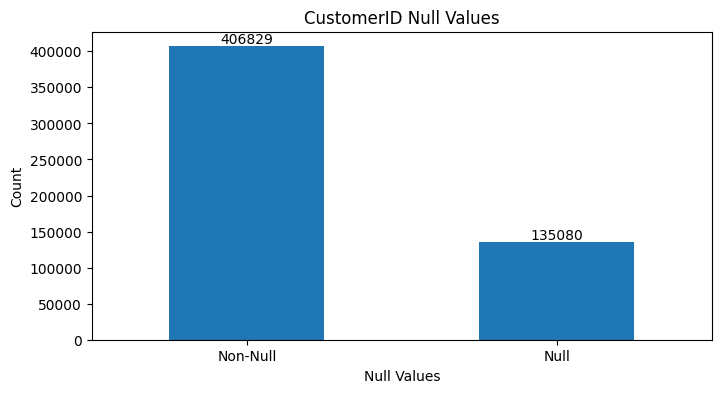

In [ ]:
# Count null and non-null values
customer_null_counts = df['CustomerID'].isnull().value_counts()
customer_null_counts.index = ['Non-Null', 'Null']

# Add labels of value on top of bars
def add_value(x, y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center', va='bottom')


# Plot
plt.figure(figsize=(8,4))
customer_null_counts.plot(kind='bar')
plt.title('CustomerID Null Values')
plt.xlabel('Null Values')
plt.ylabel('Count')
plt.xticks(rotation=0)

add_value(customer_null_counts.index, customer_null_counts.values)

plt.show()

- As shown above, there are total of 135,080 null values in the CustomerID column. Since CustomerID serves as a unique identifier for each row, retaining null values in this column could lead to inaccurate analysis or misleading results. Therefore, I'll remove all rows that contain null values in the CustomerID column.

----------

Inference for Categorical Values

In [ ]:
# statistical info for categorical values

df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


## 2-4. Inovice No

- Previously, we observed that there's odds in InvoiceNo, starting with a letter, while most InvoiceNo starts with a number.
- Referring to the tables below, a total 9,291 rows starting with a letter, 3 of them start with A, others start with C which indicates canceled items. This canceled item can be used to identify which items are canceled, and an indicator of the cancellation rates of the item.

In [ ]:
# Filter rows where the InvoiceNo starts with a letter

df[~df['InvoiceNo'].astype(str).str.match(r'^\d')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [ ]:
df[df['InvoiceNo'].astype(str).str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
df[df['InvoiceNo'].astype(str).str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


## 2-5. Stock Code

- We have 4,070 unique values in StockCode, which means we have a total of 4,070 unique items in the catalog to recommend.

In [ ]:
df[df['StockCode'] == '21169']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
117,536381,21169,YOU'RE CONFUSING ME METAL SIGN,3,12/1/2010 9:41,1.69,15311.0,United Kingdom
339,536401,21169,YOU'RE CONFUSING ME METAL SIGN,2,12/1/2010 11:21,1.69,15862.0,United Kingdom
1912,536544,21169,YOU'RE CONFUSING ME METAL SIGN,1,12/1/2010 14:32,4.21,NaN,United Kingdom
4713,536798,21169,YOU'RE CONFUSING ME METAL SIGN,24,12/2/2010 15:55,1.69,17838.0,United Kingdom
5504,536864,21169,YOU'RE CONFUSING ME METAL SIGN,2,12/3/2010 11:27,4.21,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
538283,581404,21169,YOU'RE CONFUSING ME METAL SIGN,6,12/8/2011 13:47,1.69,13680.0,United Kingdom
539423,581439,21169,YOU'RE CONFUSING ME METAL SIGN,1,12/8/2011 16:30,4.13,NaN,United Kingdom
540335,581476,21169,YOU'RE CONFUSING ME METAL SIGN,48,12/9/2011 8:48,1.45,12433.0,Norway
541340,581498,21169,YOU'RE CONFUSING ME METAL SIGN,2,12/9/2011 10:26,4.13,NaN,United Kingdom


## 2-6. Description

- can be filled by using StockCode

In [ ]:
df_negative_qty = df[df['Quantity']<0]

In [ ]:
df_canceled = df_negative_qty[~df_negative_qty['InvoiceNo'].astype(str).str.startswith('C')]
df_canceled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2406,536589,21777,NaN,-10,12/1/2010 16:50,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,12/2/2010 14:42,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,12/3/2010 15:30,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,12/3/2010 15:30,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,12/7/2011 18:36,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,12/7/2011 18:38,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,12/7/2011 18:38,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,12/8/2011 9:56,0.0,NaN,United Kingdom


In [ ]:
df[df['StockCode'] == '21777']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
19,536367,21777,RECIPE BOX WITH METAL HEART,4,12/1/2010 8:34,7.95,13047.0,United Kingdom
2140,536562,21777,RECIPE BOX WITH METAL HEART,2,12/1/2010 15:08,7.95,13468.0,United Kingdom
2399,536588,21777,RECIPE BOX WITH METAL HEART,1,12/1/2010 16:49,7.95,17069.0,United Kingdom
2406,536589,21777,NaN,-10,12/1/2010 16:50,0.00,NaN,United Kingdom
2587,536592,21777,RECIPE BOX WITH METAL HEART,2,12/1/2010 17:06,7.95,NaN,United Kingdom
10350,537237,21777,RECIPE BOX WITH METAL HEART,1,12/6/2010 9:58,7.95,NaN,United Kingdom
11104,537240,21777,RECIPE BOX WITH METAL HEART,2,12/6/2010 10:08,7.95,NaN,United Kingdom
12008,537361,21777,NaN,5,12/6/2010 12:34,0.00,NaN,United Kingdom
21702,C538112,21777,RECIPE BOX WITH METAL HEART,-3,12/9/2010 15:28,7.95,14898.0,United Kingdom
21750,C538119,21777,RECIPE BOX WITH METAL HEART,-2,12/9/2010 15:34,7.95,13136.0,United Kingdom


## 2-7. InvoiceDate

- bar plot - purchases by month for top 4 countries. bar plot split by each countries. 전체 플랏도 하나 더
=> check seasonality. seasonal effects.

## 2-8. Country

In [ ]:
df['Country'].value_counts().head(10)

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [ ]:
df['Description'].value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2369
REGENCY CAKESTAND 3 TIER,2200
JUMBO BAG RED RETROSPOT,2159
PARTY BUNTING,1727
LUNCH BAG RED RETROSPOT,1638
...,...
ANT SILVER TURQUOISE BOUDICCA RING,1
Damages,1
Found by jackie,1


So what can we do with this Data? For EDA, we can do customer segmentation by
1. country
2. how many times they purchases (group by invoice no or sum quantity)
3. season (invoice date)
4. how much they spend (unit price)

Also, we can do sales forecasting by
1. how many items be purchased

In [ ]:
df[df.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


#3. Data Pre-Processing

## 3-1. Missing Values

- Especially in CustomerID -> delete
- Description -> fill in using StockCode

## 3-2. Outlier - Quantity

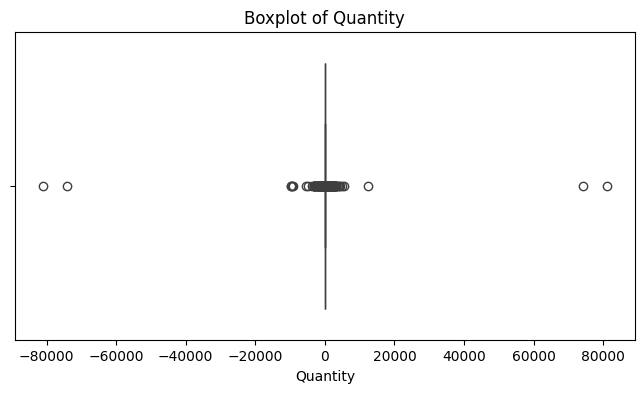

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')
plt.show()

## 3-3. Duplicated Values

"Does it really make sense?" - 한 사람이 동시에 여러개의 transaction을 만드는 것은 도저히 말이 안된다. 그렇기에 '삭제'를 해도 되는 것